In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam

In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

#  Use your exact dataset path (with raw string to handle spaces)
dataset_path = r"C:\Users\Ackah Godfred\Brain-Stroke-Detection-Using-CNN-main\Final ST\TUB\dataset"

#  Check if the path exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"🚫 Dataset path not found: {dataset_path}")
else:
    print(" Dataset path found!")
    print("📂 Subfolders:", os.listdir(dataset_path))  # Should list ['tb', 'normal']

# Constants
img_size = 224
batch_size = 32

# Create data generators with 20% validation split
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Training generator
train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation generator
val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


 Dataset path found!
📂 Subfolders: ['Normal', 'TB']
Found 2395 images belonging to 2 classes.
Found 598 images belonging to 2 classes.


In [3]:
# Load pre-trained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12  # Can increase to 15–20 if needed
)


C:\Users\Ackah Godfred\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 596s 8s/step - accuracy: 0.7745 - loss: 0.5051 - val_accuracy: 0.9783 - val_loss: 0.1247
Epoch 2/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9530 - loss: 0.1393

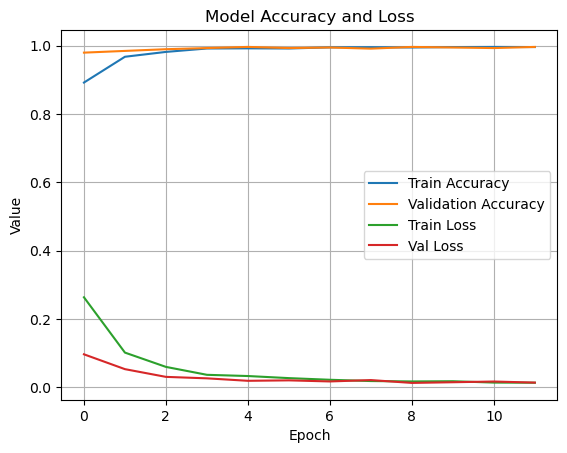

In [5]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Model Accuracy and Loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.grid(True)
plt.show()


In [6]:
val_gen.reset()
predictions = model.predict(val_gen)
pred_labels = (predictions > 0.5).astype(int).flatten()
true_labels = val_gen.classes

print("Classification Report:\n", classification_report(true_labels, pred_labels))
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))


19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       101
           1       1.00      1.00      1.00       497

    accuracy                           1.00       598
   macro avg       0.99      1.00      0.99       598
weighted avg       1.00      1.00      1.00       598

Confusion Matrix:
 [[101   0]
 [  2 495]]


In [8]:
model.save("tb_detection_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


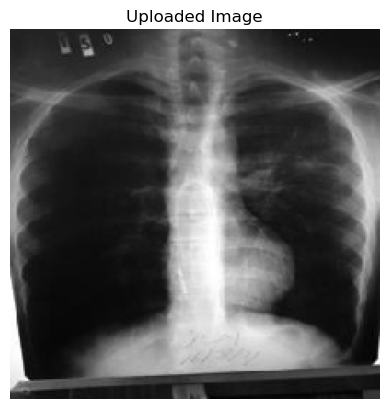

🦠 Prediction: TB Detected
Model confidence: 1.0000


In [42]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import os


img_size = 224  # Image size used during training

img_path = r"C:\Users\Ackah Godfred\Brain-Stroke-Detection-Using-CNN-main\Final ST\TUB\test/TB1.jpg" 



#  Prediction function (leave unchanged)
def predict_tb(img_path, model):
    if not os.path.exists(img_path):
        print(f"🚫 File not found: {img_path}")
        return
    
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make prediction
    prediction = model.predict(img_array)[0][0]  # Output is a single probability

    # Show image
    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded Image")
    plt.show()

    # Show result
    if prediction > 0.5:
        print("🦠 Prediction: TB Detected")
    else:
        print("🫁 Prediction: Normal (No TB)")
    print(f"Model confidence: {prediction:.4f}")


predict_tb(img_path, model)
